analysis

/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Mores.sd.nc
2020-02-09T00:00:00.000000000


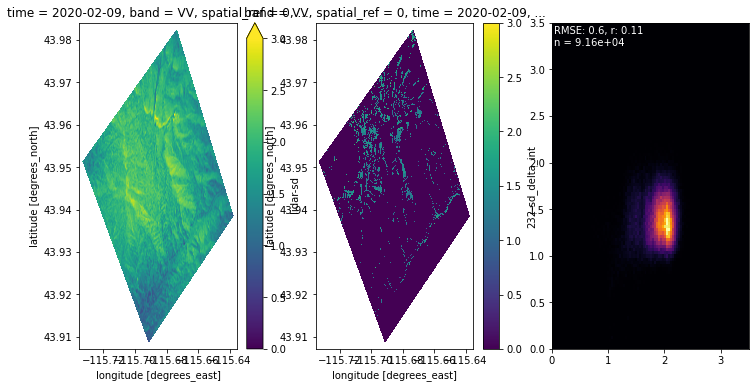

2021-03-15T00:00:00.000000000


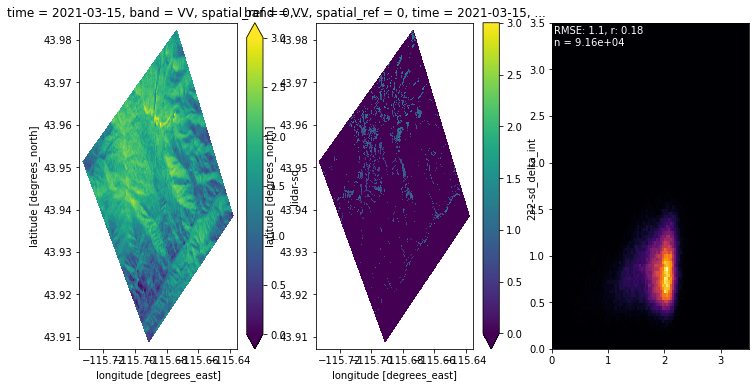

/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Banner.sd.nc
2020-02-18T00:00:00.000000000


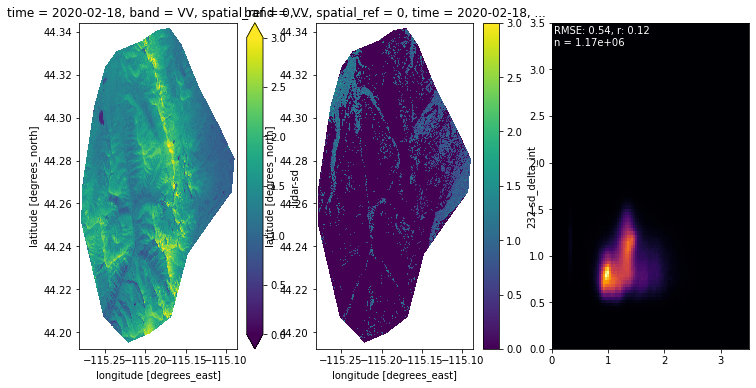

2021-03-15T00:00:00.000000000


KeyboardInterrupt: 

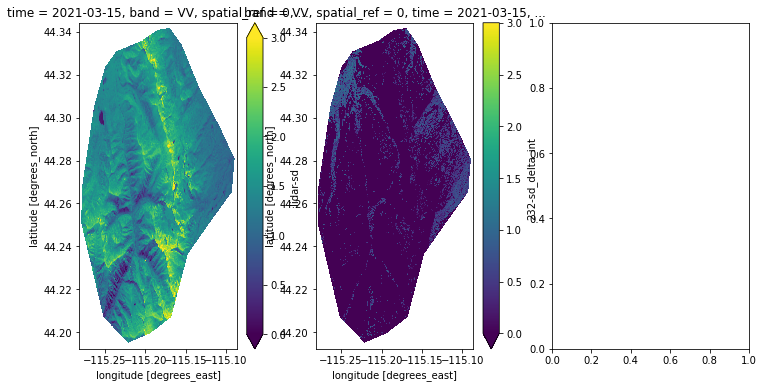

In [17]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa

from pathlib import Path
from stats import get_stats, clean_xs_ys

from scipy.ndimage import gaussian_filter

from xrspatial import slope, aspect, curvature

import matplotlib as mpl
import matplotlib.pyplot as plt

from uavsar_pytools.snow_depth_inversion import depth_from_phase, phase_from_depth

snotel_locs = {'Dry_Creek.sd': [-116.09685, 43.76377], 'Banner.sd': [-115.23447, 44.30342], 'Mores.sd': [-115.66588, 43.932]}

lidar_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar')

for lidar_fp in lidar_dir.glob('*.sd.nc'):
    print(lidar_fp)
    lidar = xr.open_dataset(lidar_fp)

    if isinstance(lidar.attrs['lidar_times'] , str):
        lidar.attrs['lidar_times'] = [lidar.attrs['lidar_times']]
    
    sntl_x, sntl_y = snotel_locs[lidar_fp.stem]
    
    for t in lidar.attrs['lidar_times']:
        fig, axes = plt.subplots(1, 3, figsize = (12, 6))
        print(t)

        t = pd.to_datetime(t)
        ds = lidar.sel(time = slice(t - pd.Timedelta('180 days'), t))
        ds = ds.sel(band = 'VV')

        # trees = ds['lidar-vh'].sel(time = t)
        # elev = ds['lidar-dem']
        lidar_slope = slope(lidar['lidar-dem'].rio.reproject('EPSG:32611')).rio.reproject_match(lidar['lidar-sd'].sel(time = t))
        # lidar_aspect = aspect(ds['lidar-dem'])
        # lidar_curvature = curvature(ds['lidar-dem'])
        
        tol = 0.00090009 # ~0.001 degrees or ~100m

        for ds_t in ds.time:

            sub = ds.sel(time = ds_t)
            if sub['232-int'].sum() == 0:
                ds['232-sd_delta_int'].loc[dict(time = ds_t)] = np.nan
                continue
            
            if sub['snotel_dSWE'] > 0:
                cur_phase = sub['232-int'].sel(x = slice(sntl_x - tol, sntl_x + tol), y = slice(sntl_y + tol, sntl_y - tol)).mean()
                sntl_inc = sub['232-inc'].sel(x = slice(sntl_x - tol, sntl_x + tol), y = slice(sntl_y + tol, sntl_y - tol)).mean()
                snotel_sd_change = sub['snotel_dSWE'] * (997 / 250)
                sd_phase = phase_from_depth(snotel_sd_change, sntl_inc, density = 250)

                data = depth_from_phase(sub['232-int'] + (sd_phase - cur_phase), sub['232-inc'], density = 250)
                # data = gaussian_filter(data, 3)
                # trees below snow surface?
                # data = data.where(trees > 5)
                # low angle
                data = data.where(lidar_slope < 10)
                # south faces
                # data = data.where((lidar_aspect) > 145 & (lidar_aspect < 220))

                ds['232-sd_delta_int'].loc[dict(time = ds_t)] = data

            else:
                ds['232-sd_delta_int'].loc[dict(time = ds_t)] = np.nan
        
        sum = ds['232-sd_delta_int'].sum(dim = 'time')

        ds['lidar-sd'].loc[dict(time = t)] = gaussian_filter(ds['lidar-sd'].sel(time = t), sigma = 3)
        ds['lidar-sd'].sel(time = t).where(lidar_slope < 10).plot(ax = axes[0], vmin = 0, vmax = 3)

        sum.where(~ds['lidar-sd'].sel(time = t).isnull()).plot(ax = axes[1], vmin = 0, vmax = 3)

        xs, ys = clean_xs_ys(ds['lidar-sd'].sel(time = t).values.ravel(), sum.values.ravel())
        xs_tmp = xs[(xs != 0) & (ys != 0)]
        ys = ys[(xs != 0) & (ys != 0)]
        xs = xs_tmp

        axes[2].hist2d(xs, ys, bins = 100, cmap = mpl.cm.inferno, range = [[0,3.5],[0,3.5]]) # , norm = mpl.colors.LogNorm()

        rmse, r, n = get_stats(xs, ys)
        axes[2].text(.01, .99, f'RMSE: {rmse:.2}, r: {r:.2}\nn = {len(xs):.2e}', ha='left', va='top', transform=axes[2].transAxes, color = 'white')

        plt.show()
        